In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

import warnings
import math
import logging

from tabulate import tabulate
from scipy.stats import linregress

# Our utilities
from Utils import *
from FinancialMetrics import *
from TitleOutOfMarket import *

## Settings

In [2]:
warnings.filterwarnings('ignore')

## Constants
The CSV files must be in the same directory of the notebook

In [3]:
ROLLING_WINDOW_SIZE = 180   # Number of days to consider in our regression
NUMBER_OF_TITLES = 10       # Number of titles inside the portfolio

CLOSING_PRICE_CSV = 'data/NASDAQ-100-CLOSING-PRICES.csv'
TBILL_CSV = 'data/13WEEKTBILLCOUPON.csv' 
CLOSING_PRICE_OF_REMOVED_CSV = 'data/CLOSING_PRICES_OF_REMOVED_TITLES.csv' 

## Data Pre-Processing
Loading the closing prices dataset. We then calculate log returns 

### Load the Closing Price Dataset
Historical closing prices (with titles swap)

In [4]:

closing_prices = pd.read_csv(CLOSING_PRICE_CSV)
closing_prices.head()

,Dates,NDX Index,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,ALGN,...,MXIM,CDW,CERN,CHKP,FOXA,FOX,INCY,TCOM,PTON,XLNX
0,3/1/2017,4911.33,29.038,NaN,103.48,72.505,103.50,76.18,NaN,NaN,...,38.62,NaN,49.40,84.57,NaN,NaN,102.320,40.49,NaN,59.07
1,4/1/2017,4937.21,29.005,NaN,104.14,72.360,103.66,77.52,NaN,NaN,...,39.03,NaN,47.93,84.92,NaN,NaN,102.840,41.34,NaN,58.64
2,5/1/2017,4964.95,29.153,NaN,105.91,71.320,103.04,76.93,NaN,NaN,...,38.44,NaN,47.65,86.66,NaN,NaN,104.810,42.80,NaN,57.93
3,6/1/2017,5007.08,29.478,NaN,108.30,71.600,103.11,79.30,NaN,NaN,...,39.74,NaN,47.55,87.24,NaN,NaN,108.305,42.50,NaN,59.05
4,9/1/2017,5024.90,29.748,NaN,108.57,71.940,102.47,79.59,NaN,NaN,...,40.65,NaN,47.99,87.20,NaN,NaN,118.525,43.24,NaN,59.06


### Calculate the log returns

In [5]:
nasdaq100_returns = get_log_returns(CLOSING_PRICE_CSV)
nasdaq100_returns.fillna(np.nan, inplace=True)
nasdaq100_returns.head()
nasdaq100_returns.head().style.applymap(color_negative_red)

,Dates,NDX Index,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,AMGN,AMZN,ANSS,ASML,ATVI,AVGO,AZN,BIDU,BIIB,BKNG,CDNS,CEG,CHTR,CMCSA,COST,CPRT,CRWD,CSCO,CSX,CTAS,CTSH,DDOG,DLTR,DOCU,DXCM,EA,EBAY,EXC,FAST,FB,FISV,FTNT,GILD,GOOG,GOOGL,HON,IDXX,ILMN,INTC,INTU,ISRG,JD,KDP,KHC,KLAC,LCID,LRCX,LULU,MAR,MCHP,MDLZ,MELI,MNST,MRNA,MRVL,MSFT,MTCH,MU,NFLX,NTES,NVDA,NXPI,ODFL,OKTA,ORLY,PANW,PAYX,PCAR,PDD,PEP,PYPL,QCOM,REGN,ROST,SBUX,SGEN,SIRI,SNPS,SPLK,SWKS,TEAM,TMUS,TSLA,TXN,VRSK,VRSN,VRTX,WBA,WDAY,XEL,ZM,ZS,SBAC,WYNN,TRIP,YHOO,MAT,TTWO,AKAM,DISCA,DISCK,NCLH,TSCO,VIAB,DISH,CA,XRAY,ESRX,HOLX,QRTEA,STX,SHPG,VOD,TFCF,TFCFA,CELG,HAS,HSIC,JBHT,VTRS,NLOK,AAL,WTW,UAL,CSGP,NTAP,WDC,BMRN,CTXS,EXPE,LBTYA,ULTA,ALXN,MXIM,CDW,CERN,CHKP,FOXA,FOX,INCY,TCOM,PTON,XLNX
1,4/1/2017,0.005256,-0.001137,nan,0.006358,-0.002002,0.001545,0.017437,nan,nan,0.009349,nan,0.014098,0.004646,nan,nan,0.019460,-0.007147,nan,0.021514,0.007992,0.006557,nan,nan,0.020024,0.011805,0.000188,nan,nan,-0.014512,0.020412,0.008475,0.014055,nan,0.025495,nan,nan,0.018273,-0.002685,nan,0.004675,0.015538,0.012130,nan,0.029496,0.000966,-0.000297,nan,nan,0.030418,-0.005205,0.002002,-0.019356,0.001161,nan,-0.005729,-0.003532,nan,0.000559,nan,-0.001941,-0.000470,-0.001115,nan,0.010485,nan,nan,-0.004484,nan,-0.008461,0.014948,0.002472,0.023063,nan,nan,nan,0.004583,nan,0.003760,0.013684,nan,nan,0.018462,0.001070,0.008941,0.014225,0.011496,nan,0.020068,nan,nan,-0.002131,nan,0.008536,0.045055,-0.001224,0.007839,nan,0.028434,0.000241,nan,nan,nan,nan,nan,nan,0.028019,0.029384,0.027019,nan,0.011185,0.011733,0.009455,0.045234,0.011658,0.019311,0.011659,0.015976,0.008155,0.024763,-0.002993,0.010947,-0.012700,0.021027,0.022580,0.008889,0.010392,-0.001686,0.014185,0.003968,nan,0.013208,0.008708,0.008602,nan,nan,nan,nan,0.015861,0.011928,0.001552,0.011495,0.022582,0.016384,0.035881,0.010560,nan,-0.030209,0.004130,nan,nan,0.005069,0.020776,nan,-0.007306
2,5/1/2017,0.005603,0.005090,nan,0.016854,-0.014477,-0.005999,-0.007640,nan,nan,-0.004352,nan,0.000719,0.030270,nan,nan,0.015405,-0.015882,nan,0.031540,-0.001633,0.010973,nan,nan,0.015722,0.003999,0.019525,nan,nan,0.002323,0.009780,-0.008819,-0.004021,nan,-0.017650,nan,nan,-0.020929,0.008365,nan,-0.011728,0.016544,-0.000368,nan,-0.004856,0.009007,0.006478,nan,nan,-0.004597,-0.001649,0.006156,0.005418,0.017258,nan,-0.005762,-0.009013,nan,-0.002239,nan,-0.006824,-0.019461,0.004454,nan,0.003687,nan,nan,0.000000,nan,-0.011244,0.018376,0.046938,-0.025713,nan,nan,nan,0.002478,nan,-0.007205,-0.016444,nan,nan,0.001462,0.001221,-0.005733,-0.013007,0.008359,nan,0.023992,nan,nan,-0.005616,nan,-0.020785,-0.001058,-0.007786,-0.003667,nan,0.025752,0.000602,nan,nan,nan,nan,nan,nan,0.006935,0.031452,0.055828,nan,0.017697,-0.039291,-0.037991,-0.004926,-0.015221,0.023759,0.006108,0.008196,-0.013114,-0.003803,-0.006014,-0.023537,-0.001791,0.012495,0.029715,0.003181,-0.000689,0.001770,0.033650,-0.005376,nan,-0.011931,0.017598,-0.017497,nan,nan,nan,nan,0.000142,-0.006699,-0.000333,0.008318,0.030472,0.012265,0.090715,-0.015232,nan,-0.005859,0.020283,nan,nan,0.018975,0.034708,nan,-0.012182
3,6/1/2017,0.008450,0.011086,nan,0.022315,0.003918,0.000679,0.030342,nan,nan,-0.001871,nan,0.024536,0.019716,nan,nan,-0.000791,0.013167,nan,-0.006161,0.004859,0.011157,nan,nan,0.006697,0.001709,-0.000491,nan,nan,0.001987,0.014229,0.003605,0.013570,nan,-0.012504,nan,nan,0.000633,0.034068,nan,-0.002362,0.022453,0.011170,nan,-0.006865,0.015161,0.014882,nan,nan,0.050219,0.003570,0.010062,0.005050,-0.001141,nan,-0.002546,0.009013,nan,0.004844,nan,0.006338,0.017265,0.001332,nan,-0.012417,nan,nan,0.008630,nan,-0.003171,-0.005630,-0.009865,0.013279,nan,nan,nan,-0.003649,nan,0.006879,0.011296,nan,nan,0.009453,-0.000305,-0.060159,-0.005802,0.011797,nan,-0.017392,nan,nan,0.005216,nan,-0.014689,0.009918,0.016727,0.008778,nan,0.004165,0.000843,nan,nan,nan,nan,nan,nan,0.031412,-0.002664,-0.015307,nan,0.003445,0.010241,0.009727,-0.006757,-0.006234,0.008237,0.009826,0.003320,-0.000686,-0.001695,0.002259,-0.004

### Load the Closing Price Dataset of stock removed from the Nasdaq-100 Index
Historical prices of removed titles

In [6]:

closing_prices_removed_titles = pd.read_csv(CLOSING_PRICE_OF_REMOVED_CSV)
closing_prices_removed_titles.head()

,Dates,NDX Index,NXPI,IDXX,SBAC,WYNN,TRIP,MELI,YHOO,ALGN,...,MXIM,CDW,CERN,CHKP,FOXA,FOX,INCY,TCOM,PTON,XLNX
0,1/3/2017,4911.33,97.66,117.60,105.53,87.46,47.51,161.02,NaN,96.96,...,38.62,51.54,49.40,84.57,NaN,NaN,102.320,40.49,NaN,59.07
1,1/4/2017,4937.21,98.30,115.95,105.68,90.28,48.86,165.82,NaN,97.77,...,39.03,52.38,47.93,84.92,NaN,NaN,102.840,41.34,NaN,58.64
2,1/5/2017,4964.95,98.40,115.96,104.28,91.44,49.20,171.28,NaN,94.82,...,38.44,51.87,47.65,86.66,NaN,NaN,104.810,42.80,NaN,57.93
3,1/6/2017,5007.08,98.21,118.36,103.52,92.43,50.77,172.16,NaN,94.08,...,39.74,51.69,47.55,87.24,NaN,NaN,108.305,42.50,NaN,59.05
4,1/9/2017,5024.90,98.11,119.02,102.99,92.75,50.92,174.11,NaN,94.79,...,40.65,51.17,47.99,87.20,NaN,NaN,118.525,43.24,NaN,59.06


### Loading the Risk Free Asset (US Treasury Bill - 3 Months)
We've used the Coupon Equivalent. The Coupon Equivalent, also called the Bond Equivalent, or the Investment Yield, is the bill's yield based on the purchase price, discount, and a 365- or 366-day year. 

In [7]:
tbill = pd.read_csv(TBILL_CSV)
tbill['DATE'] = pd.to_datetime(tbill['DATE'])
tbill = tbill.sort_values(by='DATE', ascending=True)
tbill = tbill.reset_index().drop(['index'], axis=1)
risk_free_rate = tbill['13 WEEKS COUPON EQUIVALENT'].mean()
print(f'Annual risk-free rate: {np.round(risk_free_rate, 2)}%')

Annual risk-free rate: 1.04%


## Rolling Window
We create a dataframe containing the ROLLING_WINDOW_SIZE (defult 6-month) rows of the returns dataframe based on a given starting day. In this dataframe will be removed all those titles that possibly entered or exited in that period (have nan values)

In [8]:
def get_window_returns(days):
    window_returns = nasdaq100_returns.iloc[days: days + ROLLING_WINDOW_SIZE]
    window_returns = window_returns.reset_index().drop(['index'], axis=1)

    # Remove titles that are not in the Nasdaq-100 window range
    window_returns.dropna(axis=1, how='any', inplace=True)

    # Get the name of the columns
    titles = window_returns.columns.tolist()

    # Remove the first two element (Dates, NDX Index) because I don't need them
    titles = titles[2:]

    return window_returns, titles

## Example: First 180 days

In [9]:
rolling_df, titles = get_window_returns(0)
print("In the first {} days, {} stocks will be taken from the index and analyzed.".format(ROLLING_WINDOW_SIZE, len(rolling_df.columns)))
rolling_df.head().style.applymap(color_negative_red)

In the first 180 days, 101 stocks will be taken from the index and analyzed.


,Dates,NDX Index,AAPL,ADBE,ADI,ADP,ADSK,AMAT,AMGN,AMZN,ATVI,AVGO,BIDU,BIIB,BKNG,CHTR,CMCSA,COST,CSCO,CSX,CTAS,CTSH,DLTR,EA,EBAY,FAST,FB,FISV,GILD,GOOG,GOOGL,ILMN,INTC,INTU,ISRG,JD,KHC,KLAC,LRCX,MAR,MCHP,MDLZ,MNST,MSFT,MU,NFLX,NTES,NVDA,ORLY,PAYX,PCAR,PYPL,QCOM,REGN,ROST,SBUX,SIRI,SWKS,TMUS,TSLA,TXN,VRSK,VRTX,WBA,MAT,AKAM,DISCA,DISCK,NCLH,TSCO,VIAB,DISH,CA,XRAY,ESRX,HOLX,QRTEA,STX,SHPG,VOD,TFCF,TFCFA,CELG,HAS,HSIC,VTRS,NLOK,AAL,WDC,BMRN,CTXS,EXPE,LBTYA,ULTA,ALXN,MXIM,CERN,CHKP,INCY,TCOM,XLNX
0,4/1/2017,0.005256,-0.001137,0.006358,-0.002002,0.001545,0.017437,0.009349,0.014098,0.004646,0.019460,-0.007147,0.021514,0.007992,0.006557,0.020024,0.011805,0.000188,-0.014512,0.020412,0.008475,0.014055,0.025495,0.018273,-0.002685,0.004675,0.015538,0.012130,0.029496,0.000966,-0.000297,0.030418,-0.005205,0.002002,-0.019356,0.001161,-0.005729,-0.003532,0.000559,-0.001941,-0.000470,-0.001115,0.010485,-0.004484,-0.008461,0.014948,0.002472,0.023063,0.004583,0.003760,0.013684,0.018462,0.001070,0.008941,0.014225,0.011496,0.020068,-0.002131,0.008536,0.045055,-0.001224,0.007839,0.028434,0.000241,0.027019,0.011185,0.011733,0.009455,0.045234,0.011658,0.019311,0.011659,0.015976,0.008155,0.024763,-0.002993,0.010947,-0.012700,0.021027,0.022580,0.008889,0.010392,-0.001686,0.014185,0.003968,0.013208,0.008708,0.008602,0.015861,0.011928,0.001552,0.011495,0.022582,0.016384,0.035881,0.010560,-0.030209,0.004130,0.005069,0.020776,-0.007306
1,5/1/2017,0.005603,0.005090,0.016854,-0.014477,-0.005999,-0.007640,-0.004352,0.000719,0.030270,0.015405,-0.015882,0.031540,-0.001633,0.010973,0.015722,0.003999,0.019525,0.002323,0.009780,-0.008819,-0.004021,-0.017650,-0.020929,0.008365,-0.011728,0.016544,-0.000368,-0.004856,0.009007,0.006478,-0.004597,-0.001649,0.006156,0.005418,0.017258,-0.005762,-0.009013,-0.002239,-0.006824,-0.019461,0.004454,0.003687,0.000000,-0.011244,0.018376,0.046938,-0.025713,0.002478,-0.007205,-0.016444,0.001462,0.001221,-0.005733,-0.013007,0.008359,0.023992,-0.005616,-0.020785,-0.001058,-0.007786,-0.003667,0.025752,0.000602,0.055828,0.017697,-0.039291,-0.037991,-0.004926,-0.015221,0.023759,0.006108,0.008196,-0.013114,-0.003803,-0.006014,-0.023537,-0.001791,0.012495,0.029715,0.003181,-0.000689,0.001770,0.033650,-0.005376,-0.011931,0.017598,-0.017497,0.000142,-0.006699,-0.000333,0.008318,0.030472,0.012265,0.090715,-0.015232,-0.005859,0.020283,0.018975,0.034708,-0.012182
2,6/1/2017,0.008450,0.011086,0.022315,0.003918,0.000679,0.030342,-0.001871,0.024536,0.019716,-0.000791,0.013167,-0.006161,0.004859,0.011157,0.006697,0.001709,-0.000491,0.001987,0.014229,0.003605,0.013570,-0.012504,0.000633,0.034068,-0.002362,0.022453,0.011170,-0.006865,0.015161,0.014882,0.050219,0.003570,0.010062,0.005050,-0.001141,-0.002546,0.009013,0.004844,0.006338,0.017265,0.001332,-0.012417,0.008630,-0.003171,-0.005630,-0.009865,0.013279,-0.003649,0.006879,0.011296,0.009453,-0.000305,-0.060159,-0.005802,0.011797,-0.017392,0.005216,-0.014689,0.009918,0.016727,0.008778,0.004165,0.000843,-0.015307,0.003445,0.010241,0.009727,-0.006757,-0.006234,0.008237,0.009826,0.003320,-0.000686,-0.001695,0.002259,-0.004065,-0.014444,-0.010439,-0.002665,0.017836,0.017772,0.007383,-0.010085,0.003010,-0.016998,0.014499,0.006949,-0.002413,0.006469,0.008497,0.015229,0.031072,-0.003185,0.031333,0.033260,-0.002101,0.006671,0.032802,-0.007034,0.019149
3,9/1/2017,0.003553,0.009118,0.002490,0.004737,-0.006226,0.003650,0.022833,0.013054,0.001168,-0.005555,0.002150,0.004413,0.013536,0.005947,-0.006393,0.007938,-0.011489,-0.001655,-0.014229,-0.010509,-0.022544,0.000648,-0.004694,-0.009709,-0.007337,0.012001,-0.015877,0.004626,0.000620,0.002384,0.000353,0.003557,-0.003000,0.008131,-0.000381,-0.002785,0.005796,0.011642,-0.000608,0.011554,-0.008245,-0.027107,-0.003188,0.013520,-0.000916,0.034386,0.039743,-0.008482,-0.004089,-0.012371,-0.001207,0.001830,-0.010144,0.002141,0.018556,0.008734,0.009163,-0.001763,0.009863,0.002559,-0.007922,0.042780,-0.006641,0.001640,0.003005,-0.022448,-0.022972,0.003159,0.002790,0.01

# PORTFOLIOS IMPLEMENTATION

## Ranking
Based on the sector and days to move for the moving window, the regression of stocks against the benchmark is performed and the best stocks that meet certain characteristics are selected

In [10]:
def portfolio_ranked(selector, days):
    """
    Build a portfolio, based on the selector, by taking the titles included in the index in the range [days; days + ROLLING_WINDOW_SIZE]
    :param selector: The selector to use in order to build the rank and select the titles
    :param days: The number of days to skip 
    """
    
    rolling_df, titles = get_window_returns(days)
    rank_df = pd.DataFrame(columns=['Title', 'r2', 'specific_risk', 'beta', 'alpha', 'alpha_significance', 'absolute_returns', 'systematic_risk'])

    ndx_returns = rolling_df.iloc[:, 1].values

    for title in titles:
        title_returns = rolling_df.iloc[0 : ROLLING_WINDOW_SIZE, rolling_df.columns.get_loc(title)]

        ndx_returns = sm.add_constant(ndx_returns)
        model = sm.OLS(title_returns, ndx_returns)
        result = model.fit()

        rank_df = rank_df.append({'Title': title, 'r2': result.rsquared, 'specific_risk': np.var(result.resid), 'beta': result.params[1], 'alpha': result.params[0], 'alpha_significance': result.pvalues[0], 'absolute_returns': np.sum(title_returns),  'systematic_risk': result.params[1] ** 2 * np.var(ndx_returns)}, ignore_index=True)
        rank_df['total_risk'] = rank_df['systematic_risk'] + rank_df['specific_risk']

    full_rank_df = rank_df.copy()
    if selector == 'max_r2':
        winners = rank_df.sort_values(by='r2', ascending=False).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'max_total_risk':
        winners = rank_df.sort_values(by='total_risk', ascending=False).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'min_total_risk':
        winners = rank_df.sort_values(by='total_risk', ascending=True).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'excess_return_over_total':
        rank_df['excess_over_total'] = rank_df['alpha'] / rank_df['absolute_returns']
        winners = rank_df.sort_values(by='excess_over_total', ascending=True).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'max_specific_risk':
        winners = rank_df.sort_values(by='specific_risk', ascending=False).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'absolute_returns':
        winners = rank_df.sort_values(by='absolute_returns', ascending=False).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'max_beta':
        # The same result as high_systematic_risk
        winners = rank_df.sort_values(by='beta', ascending=False).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'positive_alpha':
        rank_df = rank_df[rank_df['alpha'] > 0]
        if(rank_df.shape[0] < NUMBER_OF_TITLES):
            raise Exception("Not enought titles")
        winners = rank_df.sort_values(by='alpha', ascending=False).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'min_r2_and_high_specific_risk':
        rank_df = rank_df.sort_values(by=['r2'], ascending=True)
        rank_df = rank_df.head(int(len(titles) * 1/3))
        winners = rank_df.sort_values(by='specific_risk', ascending=False).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'min_beta':
        winners = rank_df.sort_values(by='beta', ascending=True).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'high_systematic_risk' or selector == 'low_systematic_risk':
        ascending = False
        if 'low' in selector:
            ascending = True
        winners = rank_df.sort_values(by='systematic_risk', ascending=ascending).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'positive_and_significant_alpha':
        rank_df = rank_df[rank_df['alpha_significance'] < 0.05]
        rank_df = rank_df[rank_df['alpha'] > 0]
        if(rank_df.shape[0] < NUMBER_OF_TITLES):
            raise Exception("Not enought titles")
        winners = rank_df.sort_values(by='alpha', ascending=False).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'positive_alpha_and_high_beta':
        rank_df = rank_df[rank_df['alpha'] > 0]
        winners = rank_df.sort_values(by='beta', ascending=False).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    
    return selected_titles, winners, full_rank_df

## Calculation of returns
Given the weekly returns of the selected stocks let us calculate the returns. The default weights are 1/N. If the returns are not available in the source dataset, because a stock may have exited the Nasdaq-100, we will go find the missing closing price, calculate the return, and then remove it from the portfolio 

In [11]:
def get_weekly_portfolio_returns(window_returns):
    
    returns = []
    left_the_market = [] # Keep here title already out of the portfolio

    for index, row in window_returns.iterrows():

        portfolio_components_number = NUMBER_OF_TITLES
        daily_return = 0

        for title, value in row.items():
            if math.isnan(value):
                if title in left_the_market:
                    portfolio_components_number -= 1 # Skip this title. Removed from the market and from the portfolio
                else:
                    missing_date = nasdaq100_returns.iloc[index - 1]['Dates'] # Pandas slicing objects return index + 1
                    missing_price = closing_prices_removed_titles.iloc[index][title]

                    if math.isnan(missing_price):
                        logging.info(f'{title} is nan at row {index} ({missing_date}). It was removed')

                        if title in title_out_of_the_market.keys():
                            missing_price = title_out_of_the_market[title]
                            last_closing_price = closing_prices_removed_titles.iloc[index - 1][title]
                            missing_return = np.log(missing_price) - np.log(last_closing_price)
                            daily_return += missing_return
                        else:
                            raise Exception(f'Cannot find the closing/acquisition price of {title}')   

                        left_the_market.append(title)
                    else:
                        last_closing_price = closing_prices_removed_titles.iloc[index - 1][title]
                        missing_return = np.log(missing_price) - np.log(last_closing_price)
                        daily_return += missing_return
            else:
                 daily_return += value

        if portfolio_components_number < NUMBER_OF_TITLES:
            logging.info(f'Last return: {returns[-1]}. New return: {daily_return / portfolio_components_number}. Number of titles {portfolio_components_number}')            
        returns.append(daily_return / portfolio_components_number)
            
    return returns


### Portfolio Builder
We put together the pieces obtained from the ranking procedures and returns. We then go on to calculate the different metrics.

In [12]:
def portfolio_builder(selector):
    portfolio_returns = []
    portfolio = pd.DataFrame(columns=['Dates'] + [f'Title{i}' for i in range(1 , NUMBER_OF_TITLES + 1)] + ['Returns'])
    portfolio_history = pd.DataFrame(columns=['Dates', 'Title', 'r2', 'specific_risk', 'beta', 'alpha', 'alpha_significance', 'absolute_returns'])

    titles, values, _ = portfolio_ranked(selector, 0)
    portfolio_history = portfolio_history.append(values, ignore_index=True)
       
    days_range = nasdaq100_returns.shape[0] - ROLLING_WINDOW_SIZE
    for days in range(7, days_range, 7):

        nasdaq100_window_returns = nasdaq100_returns[titles].iloc[ROLLING_WINDOW_SIZE + days - 7 : ROLLING_WINDOW_SIZE + days]

        tmp_returns = get_weekly_portfolio_returns(nasdaq100_window_returns)
        portfolio_returns = portfolio_returns + tmp_returns

        portfolio_row = {'Dates': nasdaq100_returns.iloc[ROLLING_WINDOW_SIZE + days]['Dates']}
        portfolio_row.update({f'Title{i}': titles[i - 1] for i in range(1, NUMBER_OF_TITLES + 1)})
        portfolio = portfolio.append(portfolio_row, ignore_index=True)
        titles, values, _ = portfolio_ranked(selector, days)
        portfolio_history = portfolio_history.append(values, ignore_index=True)

    portfolio_history = portfolio_history[:-NUMBER_OF_TITLES]
    dates = np.array(portfolio['Dates'])
    dates = np.repeat(dates, NUMBER_OF_TITLES)
    portfolio_history['Dates'] = dates
    return portfolio, portfolio_returns, portfolio_history
    

## Portfolio Selectors
These are the valid selectors for ranking portfolios.

In [13]:
selectors = [
    'max_r2',
    'absolute_returns',
    'min_r2_and_high_specific_risk', 
    'max_specific_risk',
    'high_systematic_risk',
    'low_systematic_risk',
    'min_beta', 
    'positive_alpha',
    'positive_and_significant_alpha',
    'positive_alpha_and_high_beta',
    'max_total_risk',
    'min_total_risk',
    'excess_return_over_total'
]

# selectors = []

In [14]:
base_metrics = pd.DataFrame(columns=['Portfolio Title', 'Annualized Returns', 'Annualized Volatility'])
advanced_metrics = pd.DataFrame(columns=['Portfolio Title', 'Sharpe Ratio', 'MDD', 'CL', 'Var 90', 'Var 95', 'Var 99', 'IR', 'M2'])
portfolios_selector_history = {}
portfolios_analysis = {}

In [15]:
days_limit = 0
for i in range(7, nasdaq100_returns.shape[0] - 180, 7):
    days_limit = i
ndx_returns = nasdaq100_returns[180: days_limit + 180]['NDX Index'].tolist()

In [16]:
for selector in selectors:
    try:
        print(f'Buildindg {selector} portfolio')        

        portfolio, returns, history = portfolio_builder(selector)
        
        portfolios_selector_history[selector] = history
        portfolios_analysis[selector] = returns

        basic_row = get_base_metrics(selector, returns)
        base_metrics = base_metrics.append(basic_row, ignore_index=True)
        advanced_row = get_advanced_metrics(selector, returns, ndx_returns, risk_free_rate)
        advanced_metrics = advanced_metrics.append(advanced_row, ignore_index=True)
        
    except Exception as e:
        print(f'Cannot build the portfolio for the selector {selector}: {str(e)}')


Buildindg max_r2 portfolio
Buildindg absolute_returns portfolio
Buildindg min_r2_and_high_specific_risk portfolio
Buildindg max_specific_risk portfolio
Buildindg high_systematic_risk portfolio
Buildindg low_systematic_risk portfolio
Buildindg min_beta portfolio
Buildindg positive_alpha portfolio
Buildindg positive_and_significant_alpha portfolio
Cannot build the portfolio for the selector positive_and_significant_alpha: Not enought titles
Buildindg positive_alpha_and_high_beta portfolio
Buildindg max_total_risk portfolio
Buildindg min_total_risk portfolio
Buildindg excess_return_over_total portfolio


In [17]:
# Adding the Nasdaq-100 to our tables
basic_row = get_base_metrics('Nasdaq-100', ndx_returns)
base_metrics = base_metrics.append(basic_row, ignore_index=True)

### Returns and Volatility

In [18]:
print(tabulate(base_metrics, headers='keys', tablefmt='psql')) 

+----+-------------------------------+----------------------+-------------------------+
|    | Portfolio Title               | Annualized Returns   | Annualized Volatility   |
|----+-------------------------------+----------------------+-------------------------|
|  0 | max_r2                        | 16.26%               | 30.05%                  |
|  1 | absolute_returns              | 9.57%                | 30.53%                  |
|  2 | min_r2_and_high_specific_risk | 6.14%                | 29.2%                   |
|  3 | max_specific_risk             | -0.79%               | 35.25%                  |
|  4 | high_systematic_risk          | 8.63%                | 38.46%                  |
|  5 | low_systematic_risk           | 13.18%               | 19.25%                  |
|  6 | min_beta                      | 13.15%               | 19.26%                  |
|  7 | positive_alpha                | 5.15%                | 28.91%                  |
|  8 | positive_alpha_and_high_b

### Advanced Metrics

In [19]:
print(tabulate(advanced_metrics, headers='keys', tablefmt='psql')) 

+----+-------------------------------+----------------+-----------+------------+------------+------------+------------+------------+-------------+
|    | Portfolio Title               |   Sharpe Ratio |       MDD |         CL |     Var 90 |     Var 95 |     Var 99 |         IR |          M2 |
|----+-------------------------------+----------------+-----------+------------+------------+------------+------------+------------+-------------|
|  0 | max_r2                        |      0.50644   | -0.319009 |  0.509824  | -0.0236161 | -0.0304939 | -0.0433954 |  0.147124  |  0.13814    |
|  1 | absolute_returns              |      0.279216  | -0.37224  |  0.257058  | -0.0242679 | -0.0312552 | -0.0443621 | -0.374972  |  0.0808451  |
|  2 | min_r2_and_high_specific_risk |      0.174381  | -0.434591 |  0.141185  | -0.023329  | -0.0300114 | -0.0425466 | -0.425863  |  0.0544106  |
|  3 | max_specific_risk             |     -0.0519942 | -0.622202 | -0.0126751 | -0.0284863 | -0.0365529 | -0.0516845 

## Analysis of some results

#### Portfolio with the highest level of R-squared

In [20]:
idx = 0 # Play with this
portfolios_selector_history['max_r2'].iloc[idx : idx + 10]

,Dates,Title,r2,specific_risk,beta,alpha,alpha_significance,absolute_returns,systematic_risk,total_risk
0,2/10/2017,FB,0.600861,0.000038,1.161801,0.000889,0.059219,0.387506,0.336740,0.336778
1,2/10/2017,GOOG,0.599868,0.000036,1.132423,-0.000289,0.528493,0.169747,0.319926,0.319962
2,2/10/2017,AMAT,0.587449,0.000097,1.801867,0.000219,0.769658,0.392228,0.809985,0.810081
3,2/10/2017,GOOGL,0.583270,0.000037,1.105663,-0.000318,0.492564,0.159295,0.304984,0.305021
4,2/10/2017,MSFT,0.575311,0.000029,0.958420,-0.000041,0.919458,0.180242,0.229162,0.229191
5,2/10/2017,ADBE,0.542516,0.000044,1.111706,0.000852,0.093291,0.370990,0.308327,0.308371
6,2/10/2017,AAPL,0.534622,0.000057,1.244978,0.000287,0.618008,0.295418,0.386683,0.386740
7,2/10/2017,TXN,0.509606,0.000055,1.166210,-0.000413,0.466200,0.153995,0.339301,0.339356
8,2/10/2017,AVGO,0.506455,0.000113,1.655574,-0.000084,0.917055,0.308999,0.683799,0.683912
9,2/10/2017,LRCX,0.504303,0.000124,1.723359,0.000782,0.356067,0.478151,0.740940,0.741063


In [21]:
mean = portfolios_selector_history['max_r2']['r2'].mean()
print(f'The average value of r-squared is: {np.round(mean, 4)}')

portfolios_selector_history['max_r2'].sort_values(by='r2', ascending=False)

The average value of r-squared is: 0.6801


,Dates,Title,r2,specific_risk,beta,alpha,alpha_significance,absolute_returns,systematic_risk,total_risk
930,5/5/2020,MSFT,0.938464,0.000049,1.156625,0.000448,0.397175,0.241141,0.334307,0.334356
940,14/5/2020,MSFT,0.936981,0.000051,1.157416,0.000551,0.305699,0.291043,0.334667,0.334718
950,26/5/2020,MSFT,0.935464,0.000052,1.156903,0.000464,0.392364,0.282964,0.334343,0.334395
920,24/4/2020,MSFT,0.934167,0.000052,1.152983,0.000627,0.248603,0.206161,0.332415,0.332467
980,24/6/2020,MSFT,0.934000,0.000055,1.152711,0.000286,0.606374,0.297998,0.331784,0.331838
...,...,...,...,...,...,...,...,...,...,...
119,23/1/2018,MCHP,0.480673,0.000096,1.304233,-0.000382,0.607671,0.170017,0.424436,0.424532
189,4/4/2018,AMZN,0.480198,0.000129,1.167776,0.001488,0.083717,0.463989,0.340349,0.340478
89,20/12/2017,MCHP,0.475848,0.000094,1.303456,-0.000226,0.757592,0.178098,0.424000,0.424094
109,11/1/2018,MCHP,0.470581,0.000098,1.302038,-0.000199,0.790992,0.195978,0.423031,0.423129


#### Portfolio of stock with better absolute return

In [22]:
idx = 0
portfolios_selector_history['absolute_returns'].iloc[idx : idx + 10]

,Dates,Title,r2,specific_risk,beta,alpha,alpha_significance,absolute_returns,systematic_risk,total_risk
0,2/10/2017,VRTX,0.153709,0.000553,1.540778,0.002283,0.203283,0.712586,0.592259,0.592812
1,2/10/2017,NVDA,0.241062,0.000547,2.026196,0.001128,0.526473,0.599815,1.024223,1.024770
2,2/10/2017,ATVI,0.242589,0.000272,1.434711,0.001624,0.196800,0.573247,0.513524,0.513796
3,2/10/2017,TSLA,0.145605,0.000441,1.331995,0.001574,0.325138,0.544164,0.442626,0.443067
4,2/10/2017,JD,0.333218,0.000223,1.621815,0.001252,0.271072,0.542991,0.656197,0.656420
5,2/10/2017,ISRG,0.200560,0.000096,0.755998,0.001893,0.012045,0.488818,0.142585,0.142681
6,2/10/2017,LRCX,0.504303,0.000124,1.723359,0.000782,0.356067,0.478151,0.740940,0.741063
7,2/10/2017,PYPL,0.346526,0.000095,1.092873,0.001452,0.052022,0.475269,0.297969,0.298064
8,2/10/2017,MU,0.360894,0.000272,1.906027,0.000521,0.678468,0.466950,0.906337,0.906609
9,2/10/2017,ILMN,0.102850,0.000358,0.984149,0.001360,0.345376,0.437460,0.241631,0.241989


In [23]:
# First week
first_week_return = pd.DataFrame()
first_week_return['Date'] = nasdaq100_returns[180:187]['Dates']
first_week_return['Log Return'] = np.array(portfolios_analysis['absolute_returns'][idx : idx + 7])
first_week_return['Log Return'] = first_week_return['Log Return']
first_week_return

,Date,Log Return
181,21/9/2017,-0.013666
182,22/9/2017,-0.003156
183,25/9/2017,-0.025036
184,26/9/2017,-0.006764
185,27/9/2017,0.016818
186,28/9/2017,0.003350
187,29/9/2017,0.011621


In [24]:
titles = list(portfolios_selector_history['absolute_returns'][0:10]['Title'])
first_week_stocks_return = nasdaq100_returns[titles].iloc[ROLLING_WINDOW_SIZE + 7 - 7 : ROLLING_WINDOW_SIZE + 7]
first_week_stocks_return.style.applymap(color_negative_red)

,VRTX,NVDA,ATVI,TSLA,JD,ISRG,LRCX,PYPL,MU,ILMN
181,-0.004331,-0.027716,-0.013787,-0.020071,-0.033405,-0.015560,-0.004286,-0.001701,-0.001669,-0.014133
182,-0.005275,-0.009784,-0.003281,-0.042901,-0.014294,0.001266,0.025502,0.006939,0.004446,0.005826
183,-0.014383,-0.045722,-0.027929,-0.017527,-0.034577,-0.013837,-0.037825,-0.024577,-0.033835,-0.000149
184,-0.004302,0.005598,-0.006134,0.000753,-0.015016,-0.000690,-0.004299,-0.008858,-0.019986,-0.014707
185,0.004100,0.021687,0.021306,-0.012474,-0.015245,0.007295,0.057063,0.006177,0.081707,-0.003433
186,0.003683,-0.000285,0.007107,-0.004026,-0.027056,0.001756,0.013455,0.009430,0.023186,0.006251
187,0.016045,0.017436,0.015151,0.004407,-0.011711,0.019306,0.017555,0.001563,0.035455,0.001005


#### Highest Systematic Risk vs Highest Specific Risk

In [25]:
idx = 0
portfolios_selector_history['high_systematic_risk'].iloc[idx : idx + 10]

,Dates,Title,r2,specific_risk,beta,alpha,alpha_significance,absolute_returns,systematic_risk,total_risk
0,2/10/2017,NVDA,0.241062,0.000547,2.026196,0.001128,0.526473,0.599815,1.024223,1.024770
1,2/10/2017,MU,0.360894,0.000272,1.906027,0.000521,0.678468,0.466950,0.906337,0.906609
2,2/10/2017,AMAT,0.587449,0.000097,1.801867,0.000219,0.769658,0.392228,0.809985,0.810081
3,2/10/2017,LRCX,0.504303,0.000124,1.723359,0.000782,0.356067,0.478151,0.740940,0.741063
4,2/10/2017,AVGO,0.506455,0.000113,1.655574,-0.000084,0.917055,0.308999,0.683799,0.683912
5,2/10/2017,NFLX,0.369296,0.000195,1.643572,0.000296,0.780910,0.375071,0.673921,0.674116
6,2/10/2017,JD,0.333218,0.000223,1.621815,0.001252,0.271072,0.542991,0.656197,0.656420
7,2/10/2017,SWKS,0.352364,0.000189,1.557655,0.000084,0.935696,0.320182,0.605305,0.605494
8,2/10/2017,VRTX,0.153709,0.000553,1.540778,0.002283,0.203283,0.712586,0.592259,0.592812
9,2/10/2017,WDC,0.282852,0.000254,1.536931,-0.000459,0.704915,0.218321,0.589306,0.589559


In [26]:
portfolios_selector_history['max_specific_risk'].iloc[idx : idx + 10]

,Dates,Title,r2,specific_risk,beta,alpha,alpha_significance,absolute_returns,systematic_risk,total_risk
0,2/10/2017,STX,0.127503,0.000639,1.484874,-0.002736,0.155994,-0.201793,0.550061,0.550700
1,2/10/2017,MAT,0.019970,0.000591,0.533200,-0.004138,0.026290,-0.640485,0.070927,0.071518
2,2/10/2017,INCY,0.136559,0.000565,1.452992,-0.000938,0.604323,0.115696,0.526694,0.527259
3,2/10/2017,VRTX,0.153709,0.000553,1.540778,0.002283,0.203283,0.712586,0.592259,0.592812
4,2/10/2017,NVDA,0.241062,0.000547,2.026196,0.001128,0.526473,0.599815,1.024223,1.024770
5,2/10/2017,AKAM,0.063874,0.000482,0.881772,-0.002897,0.084327,-0.348862,0.193974,0.194457
6,2/10/2017,ORLY,0.001172,0.000458,-0.112696,-0.001673,0.305018,-0.323228,0.003168,0.003627
7,2/10/2017,TSLA,0.145605,0.000441,1.331995,0.001574,0.325138,0.544164,0.442626,0.443067
8,2/10/2017,NTES,0.148982,0.000425,1.325811,0.000014,0.992670,0.262195,0.438525,0.438950
9,2/10/2017,CSX,0.091696,0.000412,0.991262,0.001067,0.489842,0.386243,0.245137,0.245549


#### Portfolio of stock with best excess return

In [27]:
idx = 0
portfolios_selector_history['positive_alpha'].iloc[idx : idx + 10]

,Dates,Title,r2,specific_risk,beta,alpha,alpha_significance,absolute_returns,systematic_risk,total_risk
0,2/10/2017,VRTX,0.153709,0.000553,1.540778,0.002283,0.203283,0.712586,0.592259,0.592812
1,2/10/2017,ISRG,0.200560,0.000096,0.755998,0.001893,0.012045,0.488818,0.142585,0.142681
2,2/10/2017,ATVI,0.242589,0.000272,1.434711,0.001624,0.196800,0.573247,0.513524,0.513796
3,2/10/2017,TSLA,0.145605,0.000441,1.331995,0.001574,0.325138,0.544164,0.442626,0.443067
4,2/10/2017,PYPL,0.346526,0.000095,1.092873,0.001452,0.052022,0.475269,0.297969,0.298064
5,2/10/2017,ILMN,0.102850,0.000358,0.984149,0.001360,0.345376,0.437460,0.241631,0.241989
6,2/10/2017,JD,0.333218,0.000223,1.621815,0.001252,0.271072,0.542991,0.656197,0.656420
7,2/10/2017,NVDA,0.241062,0.000547,2.026196,0.001128,0.526473,0.599815,1.024223,1.024770
8,2/10/2017,EA,0.259101,0.000159,1.144536,0.001081,0.260080,0.418724,0.326807,0.326965
9,2/10/2017,CERN,0.153864,0.000137,0.766338,0.001079,0.226305,0.344250,0.146512,0.146648


In [28]:
mean = portfolios_selector_history['positive_alpha']['alpha'].mean()
print(f'The average value of alpha is: {np.round(mean, 4)}')

portfolios_selector_history['positive_alpha'].sort_values(by='alpha', ascending=False)

The average value of alpha is: 0.0018


,Dates,Title,r2,specific_risk,beta,alpha,alpha_significance,absolute_returns,systematic_risk,total_risk
1060,14/9/2020,TSLA,0.330193,0.002229,1.336041,0.007758,0.030214,1.891236,0.444966,0.447195
1380,4/8/2021,MRNA,0.039975,0.002309,0.789530,0.007713,0.035079,1.619319,0.155382,0.157690
1050,2/9/2020,TSLA,0.339846,0.002127,1.337042,0.007636,0.028910,1.817353,0.445824,0.447951
1390,13/8/2021,MRNA,0.046260,0.002316,0.912155,0.007008,0.055179,1.481982,0.207505,0.209820
1010,24/7/2020,TSLA,0.319899,0.002024,1.268554,0.006937,0.041564,1.621643,0.401470,0.403494
...,...,...,...,...,...,...,...,...,...,...
389,22/10/2018,ADBE,0.639223,0.000112,1.159761,0.000911,0.251377,0.184737,0.336293,0.336405
779,21/11/2019,AMAT,0.480500,0.000221,1.380363,0.000868,0.438540,0.357508,0.475681,0.475902
868,25/2/2020,WDC,0.266746,0.000606,1.508786,0.000863,0.644560,0.575159,0.567461,0.568067
879,5/3/2020,SWKS,0.496235,0.000208,1.426832,0.000861,0.429872,0.470921,0.507813,0.508021


In [29]:
portfolios_selector_history['positive_alpha'].sort_values(by='beta', ascending=False)

,Dates,Title,r2,specific_risk,beta,alpha,alpha_significance,absolute_returns,systematic_risk,total_risk
1251,25/3/2021,TSLA,0.441732,0.001370,2.095073,0.004091,0.143623,1.278161,1.094724,1.096094
18,11/10/2017,NVDA,0.263557,0.000534,2.094885,0.001054,0.547663,0.547108,1.095152,1.095686
25,20/10/2017,NVDA,0.257784,0.000533,2.060613,0.001163,0.506998,0.565468,1.059586,1.060120
38,31/10/2017,NVDA,0.256286,0.000526,2.058160,0.001067,0.539574,0.538939,1.057114,1.057639
1266,6/4/2021,TSLA,0.437667,0.001335,2.055277,0.002313,0.400532,0.818628,1.054265,1.055600
...,...,...,...,...,...,...,...,...,...,...
1270,15/4/2021,DISCK,0.001429,0.001508,-0.093470,0.003493,0.233511,0.605674,0.002179,0.003687
1392,13/8/2021,DISCK,0.001349,0.001448,-0.120366,0.001812,0.528823,0.297034,0.003613,0.005061
1361,15/7/2021,DISCK,0.001856,0.001487,-0.126620,0.002622,0.367398,0.445818,0.004000,0.005487
1373,26/7/2021,DISCK,0.002286,0.001494,-0.141802,0.002113,0.469055,0.345995,0.005015,0.006509


#### Portfolio of stock with minimum total risk
where total risk = systematic risk + specific risk

In [30]:
idx = 0
portfolios_selector_history['min_total_risk'].iloc[idx : idx + 10]

,Dates,Title,r2,specific_risk,beta,alpha,alpha_significance,absolute_returns,systematic_risk,total_risk
0,2/10/2017,TSCO,0.001484,0.000277,0.098691,-0.001357,0.285068,-0.224957,0.002430,0.002707
1,2/10/2017,ORLY,0.001172,0.000458,-0.112696,-0.001673,0.305018,-0.323228,0.003168,0.003627
2,2/10/2017,COST,0.020284,0.000143,0.264130,-0.000180,0.843156,0.019345,0.017405,0.017547
3,2/10/2017,ROST,0.015743,0.000188,0.266445,-0.000702,0.501338,-0.074167,0.017711,0.017899
4,2/10/2017,DLTR,0.018114,0.000205,0.299133,0.000087,0.936316,0.074256,0.022323,0.022529
5,2/10/2017,VOD,0.043517,0.000090,0.311569,0.000468,0.518167,0.145182,0.024218,0.024308
6,2/10/2017,MNST,0.025836,0.000188,0.343631,0.000770,0.461535,0.205867,0.029459,0.029647
7,2/10/2017,PAYX,0.072053,0.000083,0.390339,-0.000662,0.340774,-0.042659,0.038012,0.038095
8,2/10/2017,ESRX,0.035739,0.000182,0.399220,-0.001077,0.295046,-0.115660,0.039761,0.039943
9,2/10/2017,DISCA,0.031266,0.000227,0.415813,-0.001974,0.086250,-0.273948,0.043135,0.043362


# Visualizing Data

#### NASDAQ-100 (NDX)

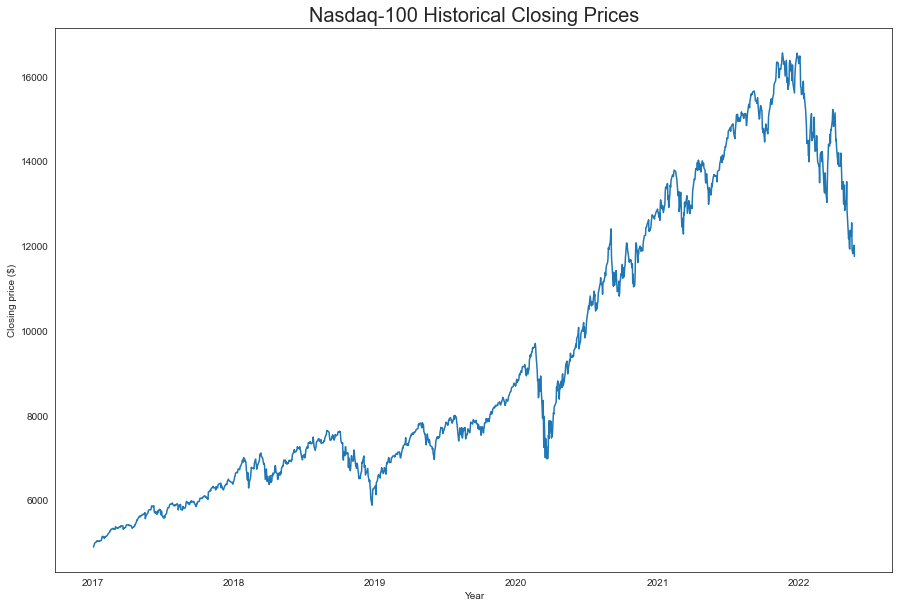

In [31]:
sns.set_style("white")
ndx_closing = closing_prices['NDX Index']
ndx_dates = pd.to_datetime(closing_prices['Dates'], dayfirst=True)
plt.figure(figsize=(15,10))
plt.plot(ndx_dates, ndx_closing, label='NDX Index')
plt.ylabel("Closing price ($)")
plt.xlabel("Year")
plt.title("Nasdaq-100 Historical Closing Prices", fontsize=20)
plt.show()

#### NASDAQ-100 (NDX) VS PORTFOLIOS

In [32]:
selectors_to_display = ['max_r2', 'absolute_returns', 'min_r2_and_high_specific_risk', 'max_specific_risk','positive_alpha_and_high_beta']

money_to_invest = 1000

dates = np.array(nasdaq100_returns[ROLLING_WINDOW_SIZE: ROLLING_WINDOW_SIZE + days_limit]['Dates']) 
dates_to_show = [dates[i] for i in np.linspace(0, len(dates) - 1, 20).astype(int)]

ndx_returns = np.array(nasdaq100_returns[ROLLING_WINDOW_SIZE: ROLLING_WINDOW_SIZE + days_limit]['NDX Index'])

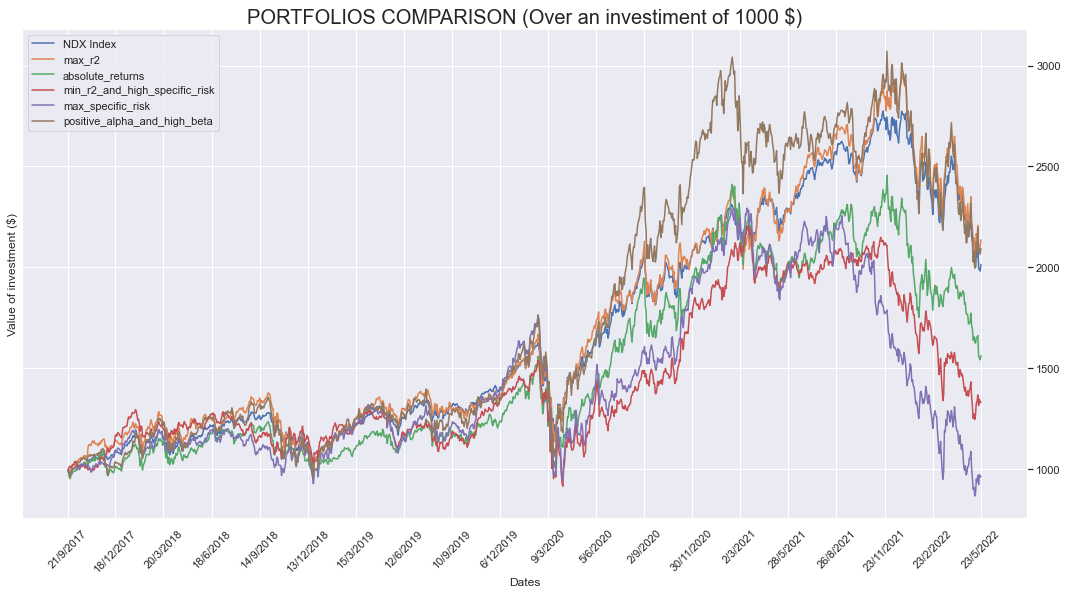

In [33]:
sns.set_theme()
sns.set(font="Verdana")
sns.set(rc={'figure.figsize':(18,9)})

legends = ['NDX Index']

returns = cumulative_returns(np.array(ndx_returns)) * money_to_invest
l = sns.lineplot(x = dates, y = returns)

l.yaxis.tick_right()
l.set_xticks(dates_to_show)
l.set_xticklabels(dates_to_show, rotation=45)
l.set_xlabel('Dates')
l.set_ylabel('Value of investment ($)')

for selector in selectors_to_display:
        legends.append(selector)
        returns = cumulative_returns(np.array(portfolios_analysis[selector])) * money_to_invest
        l = sns.lineplot(x = dates, y = returns)
l.set_title(f'PORTFOLIOS COMPARISON (Over an investiment of {money_to_invest} $)', size=20)
l.legend(labels=legends, loc='upper left')
plt.show()

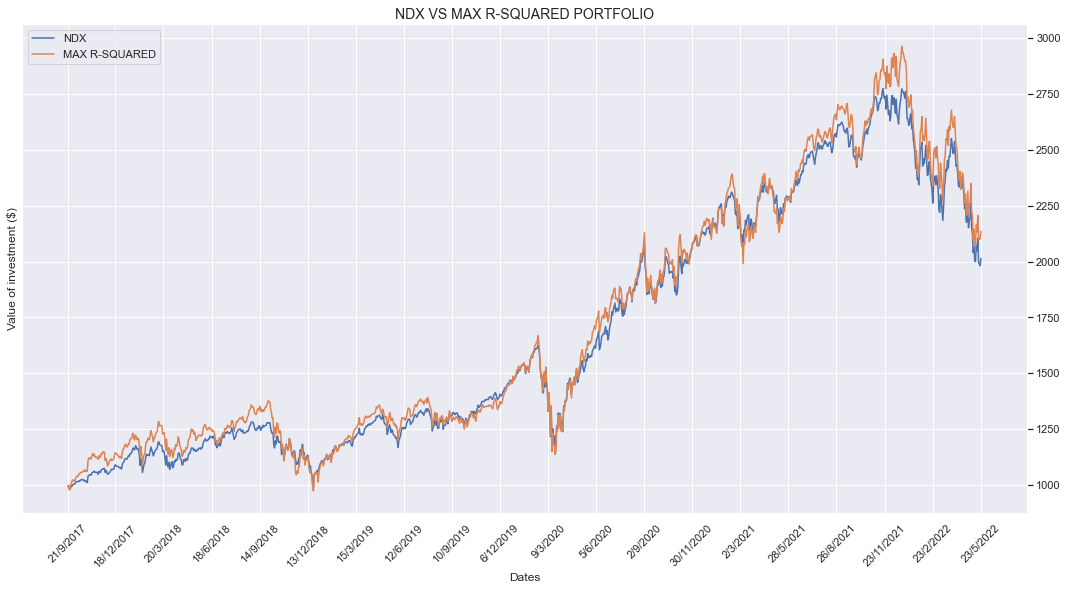

In [34]:
sns.set(font="Verdana")
sns.set(rc={'figure.figsize':(18,9)})

returns = cumulative_returns(np.array(ndx_returns)) * money_to_invest
r2_returns = cumulative_returns(np.array(portfolios_analysis['max_r2'])) * money_to_invest


l = sns.lineplot(x = dates, y = returns, linewidth = 1.5)
l1 = sns.lineplot(x = dates, y = r2_returns, linewidth = 1.5)

l.yaxis.tick_right()
l.set_xticks(dates_to_show)
l.set_xticklabels(dates_to_show, rotation=45)
l.set_xlabel('Dates')
l.set_ylabel('Value of investment ($)')
l.set_title('NDX VS MAX R-SQUARED PORTFOLIO', size=14)

l.legend(labels=['NDX', 'MAX R-SQUARED'], loc='upper left')

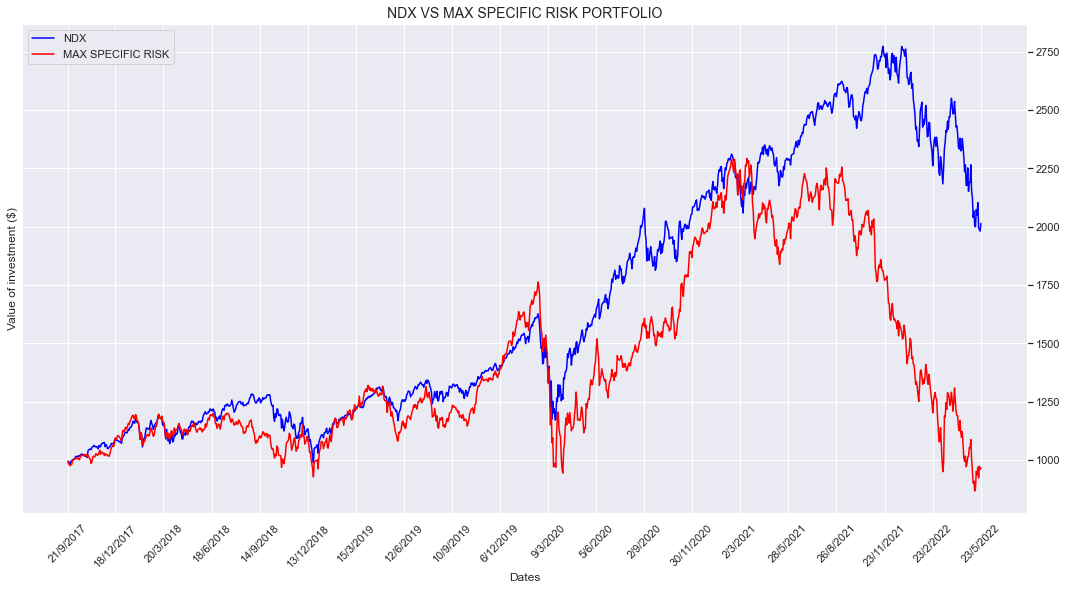

In [35]:
sns.set(font="Verdana")
sns.set(rc={'figure.figsize':(18,9)})

returns = cumulative_returns(np.array(ndx_returns)) * money_to_invest
specific_risk_returns = cumulative_returns(np.array(portfolios_analysis['max_specific_risk'])) * money_to_invest


l = sns.lineplot(x = dates, y = returns, linewidth = 1.5, color='blue')
l1 = sns.lineplot(x = dates, y = specific_risk_returns, linewidth = 1.5, color='red')

l.yaxis.tick_right()
l.set_xticks(dates_to_show)
l.set_xticklabels(dates_to_show, rotation=45)
l.set_xlabel('Dates')
l.set_ylabel('Value of investment ($)')
l.set_title('NDX VS MAX SPECIFIC RISK PORTFOLIO', size=14)

l.legend(labels=['NDX', 'MAX SPECIFIC RISK'], loc='upper left')

# Non Compulsoty Tasks
- Momentum implmentation
- A different weights schema: Inverse Volatility
- Simple Returns vs Log Returns

## Momentum
Momentum strategy is a system of buying stocks or other securities that have had high returns over the past months. There are several ways to implement a momentum strategy. In this notebook we decide to implement the Clenow Momentum (by Andreas F. Clenow). We take 1/3 of the entire titles on the basis of momentum and then we redo the calculations done previously - but on a subset.

For more details:
- https://www.amazon.com/Stocks-Move-Beating-Momentum-Strategies/dp/1511466146
- https://www.quant-investing.com/blog/this-easy-to-use-adjusted-slope-momentum-strategy-performed-7-times-better-than-the-market

In [36]:
# Reinitialization
base_metrics = pd.DataFrame(columns=['Portfolio Title', 'Annualized Returns', 'Annualized Volatility'])
advanced_metrics = pd.DataFrame(columns=['Portfolio Title', 'Sharpe Ratio', 'MDD', 'CL', 'Var 90', 'Var 95', 'Var 99', 'IR', 'M2'])
portfolios_selector_history = {}
portfolios_analysis = {}

### Core part

In [37]:
def get_clenow_momentum(title, days):
    prices = closing_prices[title].iloc[days: days + ROLLING_WINDOW_SIZE]
    prices_log = np.log(prices)
    x = np.arange(len(prices_log)) 
    slope, _, rvalue, _, _ = linregress(x, prices_log)
    m = ((1 + slope) ** 252) * (rvalue ** 2)
    return m

In [38]:
def get_window_returns_with_momentum(days):
    window_returns = nasdaq100_returns.iloc[days: days + ROLLING_WINDOW_SIZE]
    window_returns = window_returns.reset_index().drop(['index'], axis=1)

    window_returns.dropna(axis=1, how='any', inplace=True)
    titles = window_returns.columns.tolist()
    titles = titles[2:]

    momentums = pd.DataFrame(columns=['Title', 'Momentum'])
    momentums['Title'] = titles

    for index, tt in momentums.iterrows():
        momentums.at[index,'Momentum'] = get_clenow_momentum(tt.Title, days)

    # Get first 1/3 titles with the highest momentum
    momentums = momentums.sort_values(by='Momentum', ascending=False)
    momentums = momentums.iloc[:int(len(momentums) / 3)]
    momentums = momentums['Title'].tolist()


    return window_returns, momentums

In [39]:
def portfolio_ranked_with_momentum(selector, days):

    rolling_df, titles = get_window_returns_with_momentum(days) 

    rank_df = pd.DataFrame(columns=['Title', 'r2', 'specific_risk', 'beta', 'alpha', 'alpha_significance', 'absolute_returns', 'systematic_risk'])

    ndx_returns = rolling_df.iloc[:, 1].values

    for title in titles:
        title_returns = rolling_df.iloc[0 : ROLLING_WINDOW_SIZE, rolling_df.columns.get_loc(title)]

        ndx_returns = sm.add_constant(ndx_returns)
        model = sm.OLS(title_returns, ndx_returns)
        result = model.fit()

        rank_df = rank_df.append({'Title': title, 'r2': result.rsquared, 'specific_risk': np.var(result.resid), 'beta': result.params[1], 'alpha': result.params[0], 'alpha_significance': result.pvalues[0], 'absolute_returns': np.sum(title_returns),  'systematic_risk': result.params[1] ** 2 * np.var(ndx_returns)}, ignore_index=True)
        rank_df['total_risk'] = rank_df['systematic_risk'] + rank_df['specific_risk']

    full_rank_df = rank_df.copy()
    if selector == 'max_r2':
        winners = rank_df.sort_values(by='r2', ascending=False).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'max_total_risk':
        winners = rank_df.sort_values(by='total_risk', ascending=False).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'min_total_risk':
        winners = rank_df.sort_values(by='total_risk', ascending=True).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'excess_return_over_total':
        rank_df['excess_over_total'] = rank_df['alpha'] / rank_df['absolute_returns']
        winners = rank_df.sort_values(by='excess_over_total', ascending=True).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'max_specific_risk':
        winners = rank_df.sort_values(by='specific_risk', ascending=False).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'absolute_returns':
        winners = rank_df.sort_values(by='absolute_returns', ascending=False).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'max_beta':
        # The same result as high_systematic_risk
        winners = rank_df.sort_values(by='beta', ascending=False).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'positive_alpha':
        rank_df = rank_df[rank_df['alpha'] > 0]
        if(rank_df.shape[0] < NUMBER_OF_TITLES):
            raise Exception("Not enought titles")
        winners = rank_df.sort_values(by='alpha', ascending=False).head(NUMBER_OF_TITLES)
    elif selector == 'min_r2_and_high_specific_risk':
        rank_df = rank_df.sort_values(by=['r2'], ascending=True)
        rank_df = rank_df.head(int(len(titles) * 1/3))
        winners = rank_df.sort_values(by='specific_risk', ascending=False).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'min_beta':
        winners = rank_df.sort_values(by='beta', ascending=True).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'high_systematic_risk' or selector == 'low_systematic_risk':
        ascending = False
        if 'low' in selector:
            ascending = True
        winners = rank_df.sort_values(by='systematic_risk', ascending=ascending).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'positive_and_significant_alpha':
        rank_df = rank_df[rank_df['alpha_significance'] < 0.05]
        rank_df = rank_df[rank_df['alpha'] > 0]
        if(rank_df.shape[0] < NUMBER_OF_TITLES):
            raise Exception("Not enought titles")
        winners = rank_df.sort_values(by='alpha', ascending=False).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    elif selector == 'positive_alpha_and_high_beta':
        rank_df = rank_df[rank_df['alpha'] > 0]
        winners = rank_df.sort_values(by='beta', ascending=False).head(NUMBER_OF_TITLES)
        selected_titles = winners['Title'].tolist()
    
    return selected_titles, winners, full_rank_df

In [40]:
def portfolio_builder_with_momentum(selector):
    portfolio_returns = []
    portfolio = pd.DataFrame(columns=['Dates'] + [f'Title{i}' for i in range(1,11)] + ['Returns'])
    portfolio_history = pd.DataFrame(columns=['Dates', 'Title', 'r2', 'specific_risk', 'beta', 'alpha', 'alpha_significance', 'absolute_returns'])

    titles, values, _ = portfolio_ranked_with_momentum(selector, 0)
    portfolio_history = portfolio_history.append(values, ignore_index=True)
       
    days_range = nasdaq100_returns.shape[0] - ROLLING_WINDOW_SIZE
    for days in range(7, days_range, 7):

        nasdaq100_window_returns = nasdaq100_returns[titles].iloc[ROLLING_WINDOW_SIZE + days - 7 : ROLLING_WINDOW_SIZE + days]

        tmp_returns = get_weekly_portfolio_returns(nasdaq100_window_returns)
        portfolio_returns = portfolio_returns + tmp_returns

        portfolio_row = {'Dates': nasdaq100_returns.iloc[ROLLING_WINDOW_SIZE + days]['Dates']}
        portfolio_row.update({f'Title{i}': titles[i - 1] for i in range(1,11)})
        portfolio = portfolio.append(portfolio_row, ignore_index=True)

        titles, values, _ = portfolio_ranked_with_momentum(selector, days)
        portfolio_history = portfolio_history.append(values, ignore_index=True)

    portfolio_history = portfolio_history[:-10]
    dates = np.array(portfolio['Dates'])
    dates = np.repeat(dates, 10)
    portfolio_history['Dates'] = dates
    return portfolio, portfolio_returns, portfolio_history
    

In [41]:
for selector in selectors:
    try:
        print(f'Buildindg {selector} portfolio')        
        portfolio, returns, history = portfolio_builder_with_momentum(selector)
        portfolios_selector_history[selector] = history
        portfolios_analysis[selector] = returns
        basic_row = get_base_metrics(selector, returns)
        base_metrics = base_metrics.append(basic_row, ignore_index=True)
        advanced_row = get_advanced_metrics(selector, returns, ndx_returns, risk_free_rate)
        advanced_metrics = advanced_metrics.append(advanced_row, ignore_index=True)
    except Exception as e:
        print(f'Cannot build the portfolio for the selector {selector}: {str(e)}')


Buildindg max_r2 portfolio
Buildindg absolute_returns portfolio
Buildindg min_r2_and_high_specific_risk portfolio
Buildindg max_specific_risk portfolio
Buildindg high_systematic_risk portfolio
Buildindg low_systematic_risk portfolio
Buildindg min_beta portfolio
Buildindg positive_alpha portfolio
Cannot build the portfolio for the selector positive_alpha: local variable 'selected_titles' referenced before assignment
Buildindg positive_and_significant_alpha portfolio
Cannot build the portfolio for the selector positive_and_significant_alpha: Not enought titles
Buildindg positive_alpha_and_high_beta portfolio
Buildindg max_total_risk portfolio
Buildindg min_total_risk portfolio
Buildindg excess_return_over_total portfolio


In [42]:
print(tabulate(base_metrics, headers='keys', tablefmt='psql')) 
print(tabulate(advanced_metrics, headers='keys', tablefmt='psql')) 

+----+-------------------------------+----------------------+-------------------------+
|    | Portfolio Title               | Annualized Returns   | Annualized Volatility   |
|----+-------------------------------+----------------------+-------------------------|
|  0 | max_r2                        | 13.8%                | 30.67%                  |
|  1 | absolute_returns              | 15.18%               | 30.19%                  |
|  2 | min_r2_and_high_specific_risk | 7.15%                | 21.71%                  |
|  3 | max_specific_risk             | 11.84%               | 29.63%                  |
|  4 | high_systematic_risk          | 17.02%               | 34.98%                  |
|  5 | low_systematic_risk           | 3.45%                | 19.62%                  |
|  6 | min_beta                      | 3.45%                | 19.62%                  |
|  7 | positive_alpha_and_high_beta  | 15.84%               | 34.31%                  |
|  8 | max_total_risk           

In [43]:
print(tabulate(advanced_metrics, headers='keys', tablefmt='psql')) 

+----+-------------------------------+----------------+-----------+----------+------------+------------+------------+------------+-----------+
|    | Portfolio Title               |   Sharpe Ratio |       MDD |       CL |     Var 90 |     Var 95 |     Var 99 |         IR |        M2 |
|----+-------------------------------+----------------+-----------+----------+------------+------------+------------+------------+-----------|
|  0 | max_r2                        |       0.415989 | -0.324446 | 0.425407 | -0.0242118 | -0.0312308 | -0.0443973 | -0.112278  | 0.115333  |
|  1 | absolute_returns              |       0.468196 | -0.339194 | 0.447477 | -0.0237689 | -0.0306779 | -0.0436378 |  0.0118272 | 0.128497  |
|  2 | min_r2_and_high_specific_risk |       0.28113  | -0.260577 | 0.274246 | -0.0172398 | -0.0222074 | -0.0315258 | -0.519758  | 0.0813276 |
|  3 | max_specific_risk             |       0.364244 | -0.379188 | 0.312158 | -0.0234508 | -0.030232  | -0.0429522 | -0.221401  | 0.102285  |

## New Weights Schema
In inverse volatility strategy the risk is measured with volatility, and assets are weighted in inverse proportion to their risk. An inverse volatility weighted portfolio is one in which highly volatile assets are assigned smaller weights and low volatile assets are allotted larger weights.

In [44]:
# Reinitialization
base_metrics = pd.DataFrame(columns=['Portfolio Title', 'Annualized Returns', 'Annualized Volatility'])
advanced_metrics = pd.DataFrame(columns=['Portfolio Title', 'Sharpe Ratio', 'MDD', 'CL', 'Var 90', 'Var 95', 'Var 99', 'IR', 'M2'])
portfolios_selector_history = {}
portfolios_analysis = {}

In [45]:
def get_weekly_portfolio_returns_inverse_volatility(window_returns, days):
    
    returns = []
    left_the_market = []
    title_volatility = {}

    # Get past returns - decide a priori weights
    titles = list(window_returns.columns)
    nasdaq100_past_returns = nasdaq100_returns[titles].iloc[days - 7 : ROLLING_WINDOW_SIZE + days - 7]
    for title in titles:
        title_returns = nasdaq100_past_returns[title] 
        title_volatility[title] = 1 / title_returns.std()

    for index, row in window_returns.iterrows():
        daily_return = 0
        total_volatility = 0

        # Get total volatility
        for title, value in row.items():
            if math.isnan(value):
                if title in left_the_market:
                    pass
                else:
                    missing_price = closing_prices_removed_titles.iloc[index][title]
                    if math.isnan(missing_price):
                        if title in title_out_of_the_market.keys():
                            total_volatility += title_volatility[title]
                        else:
                            raise Exception(f'Cannot find the closing/acquisition price of {title}')   
                        left_the_market.append(title)
                    else:
                        total_volatility += title_volatility[title]
            else:
                 total_volatility += title_volatility[title]

        for title, value in row.items():
            if math.isnan(value):
                if title in left_the_market:
                    pass
                else:
                    missing_price = closing_prices_removed_titles.iloc[index][title]
                    if math.isnan(missing_price):
                        missing_price = title_out_of_the_market[title]
                        last_closing_price = closing_prices_removed_titles.iloc[index - 1][title]
                        missing_return = np.log(missing_price) - np.log(last_closing_price)
                        daily_return += missing_return * (title_volatility[title] / total_volatility)
                        left_the_market.append(title)
                    else:
                        last_closing_price = closing_prices_removed_titles.iloc[index - 1][title]
                        missing_return = np.log(missing_price) - np.log(last_closing_price)
                        daily_return += missing_return * (title_volatility[title] / total_volatility)
            else:
                 daily_return += value * (title_volatility[title] / total_volatility)

        returns.append(daily_return)
            
    return returns


In [46]:
def portfolio_builder_inverse_volatility(selector):
    portfolio_returns = []
    portfolio = pd.DataFrame(columns=['Dates'] + [f'Title{i}' for i in range(1 , NUMBER_OF_TITLES + 1)] + ['Returns'])
    portfolio_history = pd.DataFrame(columns=['Dates', 'Title', 'r2', 'specific_risk', 'beta', 'alpha', 'alpha_significance', 'absolute_returns'])

    titles, values, _ = portfolio_ranked(selector, 0)
    portfolio_history = portfolio_history.append(values, ignore_index=True)
       
    days_range = nasdaq100_returns.shape[0] - ROLLING_WINDOW_SIZE
    for days in range(7, days_range, 7):

        nasdaq100_window_returns = nasdaq100_returns[titles].iloc[ROLLING_WINDOW_SIZE + days - 7 : ROLLING_WINDOW_SIZE + days]

        tmp_returns = get_weekly_portfolio_returns_inverse_volatility(nasdaq100_window_returns, days)
        portfolio_returns = portfolio_returns + tmp_returns

        portfolio_row = {'Dates': nasdaq100_returns.iloc[ROLLING_WINDOW_SIZE + days]['Dates']}
        portfolio_row.update({f'Title{i}': titles[i - 1] for i in range(1, NUMBER_OF_TITLES + 1)})
        portfolio = portfolio.append(portfolio_row, ignore_index=True)
        titles, values, _ = portfolio_ranked(selector, days)
        portfolio_history = portfolio_history.append(values, ignore_index=True)

    portfolio_history = portfolio_history[:-NUMBER_OF_TITLES]
    dates = np.array(portfolio['Dates'])
    dates = np.repeat(dates, NUMBER_OF_TITLES)
    portfolio_history['Dates'] = dates
    return portfolio, portfolio_returns, portfolio_history
    

In [47]:
for selector in selectors:
    try:
        print(f'Buildindg {selector} portfolio')        

        portfolio, returns, history = portfolio_builder_inverse_volatility(selector)
        
        portfolios_selector_history[selector] = history
        portfolios_analysis[selector] = returns

        basic_row = get_base_metrics(selector, returns)
        base_metrics = base_metrics.append(basic_row, ignore_index=True)
        advanced_row = get_advanced_metrics(selector, returns, ndx_returns, risk_free_rate)
        advanced_metrics = advanced_metrics.append(advanced_row, ignore_index=True)
        
    except Exception as e:
        print(f'Cannot build the portfolio for the selector {selector}: {str(e)}')


Buildindg max_r2 portfolio
Buildindg absolute_returns portfolio
Buildindg min_r2_and_high_specific_risk portfolio
Buildindg max_specific_risk portfolio
Buildindg high_systematic_risk portfolio
Buildindg low_systematic_risk portfolio
Buildindg min_beta portfolio
Buildindg positive_alpha portfolio
Buildindg positive_and_significant_alpha portfolio
Cannot build the portfolio for the selector positive_and_significant_alpha: Not enought titles
Buildindg positive_alpha_and_high_beta portfolio
Buildindg max_total_risk portfolio
Buildindg min_total_risk portfolio
Buildindg excess_return_over_total portfolio


In [48]:
print(tabulate(base_metrics, headers='keys', tablefmt='psql')) 
print(tabulate(advanced_metrics, headers='keys', tablefmt='psql')) 

+----+-------------------------------+----------------------+-------------------------+
|    | Portfolio Title               | Annualized Returns   | Annualized Volatility   |
|----+-------------------------------+----------------------+-------------------------|
|  0 | max_r2                        | 17.06%               | 29.48%                  |
|  1 | absolute_returns              | 10.13%               | 28.94%                  |
|  2 | min_r2_and_high_specific_risk | 7.94%                | 27.62%                  |
|  3 | max_specific_risk             | -0.44%               | 34.09%                  |
|  4 | high_systematic_risk          | 8.16%                | 38.02%                  |
|  5 | low_systematic_risk           | 12.48%               | 18.57%                  |
|  6 | min_beta                      | 12.51%               | 18.58%                  |
|  7 | positive_alpha                | 5.07%                | 26.98%                  |
|  8 | positive_alpha_and_high_b

## Simple return vs Log returns
Here we transform log returns to simple returns and see how portfolios returns change

In [49]:
# Reinitialization
base_metrics = pd.DataFrame(columns=['Portfolio Title', 'Annualized Returns', 'Annualized Volatility'])
advanced_metrics = pd.DataFrame(columns=['Portfolio Title', 'Sharpe Ratio', 'MDD', 'CL', 'Var 90', 'Var 95', 'Var 99', 'IR', 'M2'])
portfolios_selector_history = {}
portfolios_analysis = {}

In [50]:
def get_weekly_portfolio_returns_with_simple_returns(window_returns):
    
    #Apply the conversion
    window_returns = np.exp(window_returns) - 1

    returns = []
    left_the_market = []
    for index, row in window_returns.iterrows():
        portfolio_components_number = NUMBER_OF_TITLES
        daily_return = 0
        for title, value in row.items():
            if math.isnan(value):
                if title in left_the_market:
                    portfolio_components_number -= 1
                else:
                    missing_price = closing_prices_removed_titles.iloc[index][title]
                    if math.isnan(missing_price):
                        if title in title_out_of_the_market.keys():
                            missing_price = title_out_of_the_market[title]
                            last_closing_price = closing_prices_removed_titles.iloc[index - 1][title]
                            missing_return = (missing_price - last_closing_price) / last_closing_price
                            daily_return += missing_return
                        else:
                            raise Exception(f'Cannot find the closing/acquisition price of {title}')   
                        left_the_market.append(title)
                    else:
                        last_closing_price = closing_prices_removed_titles.iloc[index - 1][title]
                        missing_return = (missing_price - last_closing_price) / last_closing_price
                        daily_return += missing_return
            else:
                 daily_return += value
        returns.append(daily_return / portfolio_components_number)  
    return returns


In [51]:
def portfolio_builder_with_simple_returns(selector):
    portfolio_returns = []
    portfolio = pd.DataFrame(columns=['Dates'] + [f'Title{i}' for i in range(1 , NUMBER_OF_TITLES + 1)] + ['Returns'])
    portfolio_history = pd.DataFrame(columns=['Dates', 'Title', 'r2', 'specific_risk', 'beta', 'alpha', 'alpha_significance', 'absolute_returns'])

    titles, values, _ = portfolio_ranked(selector, 0)
    portfolio_history = portfolio_history.append(values, ignore_index=True)
       
    days_range = nasdaq100_returns.shape[0] - ROLLING_WINDOW_SIZE
    for days in range(7, days_range, 7):

        nasdaq100_window_returns = nasdaq100_returns[titles].iloc[ROLLING_WINDOW_SIZE + days - 7 : ROLLING_WINDOW_SIZE + days]

        tmp_returns = get_weekly_portfolio_returns_with_simple_returns(nasdaq100_window_returns)
        portfolio_returns = portfolio_returns + tmp_returns

        portfolio_row = {'Dates': nasdaq100_returns.iloc[ROLLING_WINDOW_SIZE + days]['Dates']}
        portfolio_row.update({f'Title{i}': titles[i - 1] for i in range(1, NUMBER_OF_TITLES + 1)})
        portfolio = portfolio.append(portfolio_row, ignore_index=True)
        titles, values, _ = portfolio_ranked(selector, days)
        portfolio_history = portfolio_history.append(values, ignore_index=True)

    portfolio_history = portfolio_history[:-NUMBER_OF_TITLES]
    dates = np.array(portfolio['Dates'])
    dates = np.repeat(dates, NUMBER_OF_TITLES)
    portfolio_history['Dates'] = dates
    return portfolio, portfolio_returns, portfolio_history
    

In [52]:
for selector in selectors:
    try:
        print(f'Buildindg {selector} portfolio')        

        portfolio, returns, history = portfolio_builder_with_simple_returns(selector)
        
        portfolios_selector_history[selector] = history
        portfolios_analysis[selector] = returns

        basic_row = get_base_metrics(selector, returns)
        base_metrics = base_metrics.append(basic_row, ignore_index=True)
        advanced_row = get_advanced_metrics(selector, returns, ndx_returns, risk_free_rate)
        advanced_metrics = advanced_metrics.append(advanced_row, ignore_index=True)
        
    except Exception as e:
        print(f'Cannot build the portfolio for the selector {selector}: {str(e)}')


Buildindg max_r2 portfolio
Buildindg absolute_returns portfolio
Buildindg min_r2_and_high_specific_risk portfolio
Buildindg max_specific_risk portfolio
Buildindg high_systematic_risk portfolio
Buildindg low_systematic_risk portfolio
Buildindg min_beta portfolio
Buildindg positive_alpha portfolio
Buildindg positive_and_significant_alpha portfolio
Cannot build the portfolio for the selector positive_and_significant_alpha: Not enought titles
Buildindg positive_alpha_and_high_beta portfolio
Buildindg max_total_risk portfolio
Buildindg min_total_risk portfolio
Buildindg excess_return_over_total portfolio


In [53]:
# Adding the Nasdaq-100 to our tables
ndx_simple_returns = np.exp(ndx_returns) - 1
basic_row = get_base_metrics('Nasdaq-100', ndx_simple_returns)
base_metrics = base_metrics.append(basic_row, ignore_index=True)

In [54]:
print(tabulate(base_metrics, headers='keys', tablefmt='psql')) 
print(tabulate(advanced_metrics, headers='keys', tablefmt='psql')) 

+----+-------------------------------+----------------------+-------------------------+
|    | Portfolio Title               | Annualized Returns   | Annualized Volatility   |
|----+-------------------------------+----------------------+-------------------------|
|  0 | max_r2                        | 22.8%                | 29.92%                  |
|  1 | absolute_returns              | 19.37%               | 30.32%                  |
|  2 | min_r2_and_high_specific_risk | 17.95%               | 29.25%                  |
|  3 | max_specific_risk             | 14.09%               | 35.49%                  |
|  4 | high_systematic_risk          | 21.45%               | 38.34%                  |
|  5 | low_systematic_risk           | 18.01%               | 19.2%                   |
|  6 | min_beta                      | 17.98%               | 19.21%                  |
|  7 | positive_alpha                | 14.29%               | 28.7%                   |
|  8 | positive_alpha_and_high_b